## Median of gradient

In [1]:
import os
import cv2
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = 10, 6
plt.rcParams["image.cmap"] = "gray"

In [2]:
path_clean = "dataset/istock/clean"
path_marked = "dataset/istock/watermarked"

In [3]:
def load_imgs(dir_path):
    imgs = []
    for img_path in sorted(os.listdir(dir_path)):
        img = cv2.cvtColor(cv2.imread(dir_path + "/" + img_path), cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (img.shape[1] * 600 // img.shape[0], 600))
        imgs.append(img)
    return imgs

clean_imgs = load_imgs(path_clean)
marked_imgs = load_imgs(path_marked)

In [4]:
max_width = max([img.shape[1] for img in marked_imgs[:16]])
max_width

1067

In [22]:
padded_marked_imgs_train = [np.pad(img, ((0, 0), (0, max_width - img.shape[1]))) for img in marked_imgs[:24]]

In [37]:
edges = np.stack([
    skimage.feature.canny(
        img, sigma=0.7, low_threshold=0, high_threshold=1
    ) for img in padded_marked_imgs_train
])

med_grad = np.median(edges, axis=0)

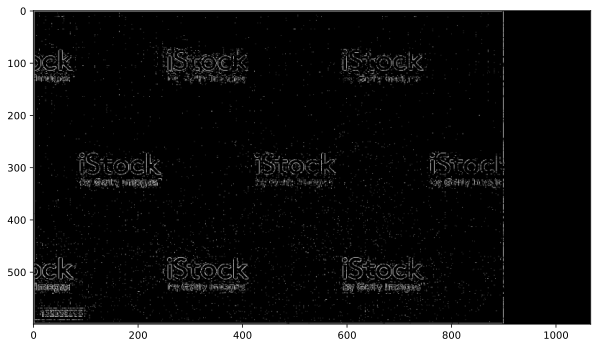

In [38]:
plt.imshow(med_grad)
plt.show()

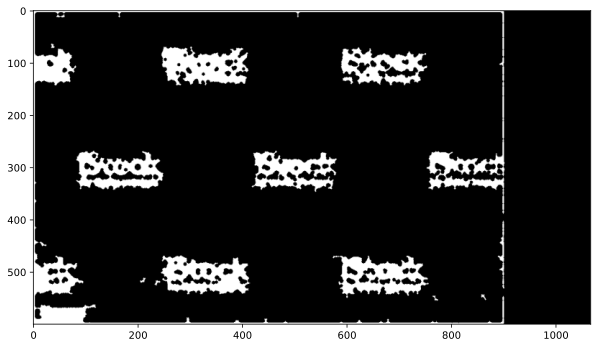

In [39]:
from skimage.morphology import dilation, remove_small_objects, remove_small_holes, binary_closing, disk

morph_grad = dilation(med_grad.astype(bool))
morph_grad = remove_small_objects(morph_grad, min_size=8)
morph_grad = binary_closing(morph_grad, footprint=disk(3))
morph_grad = remove_small_objects(morph_grad, min_size=32)
#morph_grad = remove_small_holes(morph_grad, area_threshold=128)
#morph_grad = dilation(morph_grad, disk(3))

plt.imshow(morph_grad)

In [40]:
test_img = marked_imgs[-1]
clean_test_img = clean_imgs[-1]

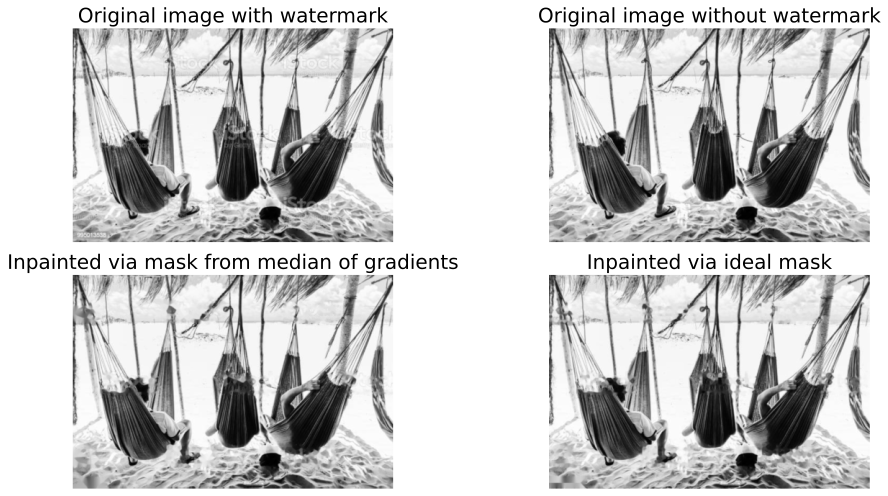

In [41]:
ideal_mask = cv2.cvtColor(cv2.imread("dataset/istock/mask.jpg"), cv2.COLOR_BGR2GRAY)
ideal_mask = cv2.resize(ideal_mask, (ideal_mask.shape[1] * 600 // ideal_mask.shape[0], 600))
ideal_mask = np.pad(ideal_mask, ((0, 0), (0, max_width - ideal_mask.shape[1])))

inpaint_grad = cv2.inpaint(test_img, np.uint8(morph_grad)[:test_img.shape[0], :test_img.shape[1]], 3, cv2.INPAINT_TELEA)
inpaint_ideal = cv2.inpaint(test_img, np.uint8(ideal_mask)[:test_img.shape[0], :test_img.shape[1]], 3, cv2.INPAINT_TELEA)

fig = plt.figure(figsize=(15, 7))
fig.add_subplot(2, 2, 1)
plt.title(f"Original image with watermark", fontsize=20)
plt.imshow(test_img, cmap="gray")
plt.axis("off")

fig.add_subplot(2, 2, 2)
plt.title(f"Original image without watermark", fontsize=20)
plt.imshow(clean_test_img, cmap="gray")
plt.axis("off")

fig.add_subplot(2, 2, 3)
plt.title(f"Inpainted via mask from median of gradients", fontsize=20)
plt.imshow(inpaint_grad, cmap="gray")
plt.axis("off")

fig.add_subplot(2, 2, 4)
plt.title(f"Inpainted via ideal mask", fontsize=20)
plt.imshow(inpaint_ideal, cmap="gray")
plt.axis("off")

plt.tight_layout()

plt.show()

In [42]:
from skimage.metrics import peak_signal_noise_ratio as psnr

clean2marked = []
clean2ideal = []
clean2medgrad = []

for test_img, clean_test_img in zip(marked_imgs[24:], clean_imgs[24:]):
    
    if test_img.shape != clean_test_img.shape:
        test_img = cv2.resize(test_img, clean_test_img.shape[::-1])
    
    inpaint_grad = cv2.inpaint(test_img, np.uint8(morph_grad)[:test_img.shape[0], :test_img.shape[1]], 3, cv2.INPAINT_TELEA)
    inpaint_ideal = cv2.inpaint(test_img, np.uint8(ideal_mask)[:test_img.shape[0], :test_img.shape[1]], 3, cv2.INPAINT_TELEA)

    #print(test_img.shape, clean_test_img.shape)
    
    clean2ideal.append(psnr(clean_test_img, inpaint_ideal))
    clean2marked.append(psnr(clean_test_img, test_img))
    clean2medgrad.append(psnr(clean_test_img, inpaint_grad))

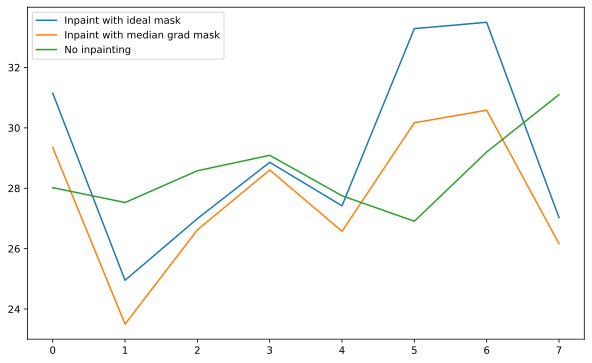

In [43]:
plt.plot(clean2ideal, label="Inpaint with ideal mask")
plt.plot(clean2medgrad, label="Inpaint with median grad mask")
plt.plot(clean2marked, label="No inpainting")
plt.legend()

In [44]:
np.mean(clean2ideal), np.mean(clean2marked), np.mean(clean2medgrad)

(29.14868907960622, 28.52263217324508, 27.697080028181404)

In [45]:
np.std(clean2ideal), np.std(clean2marked), np.std(clean2medgrad)

(2.9543863610683463, 1.218390582170403, 2.2463063644876486)

As expected, ideal mask is strictly better than med-grad mask.

Inpainting with medgrad is sometimes worse, than marked image, with respect to PSNR, presumably because inpainting creates artifacts, which significantly affect the metric.

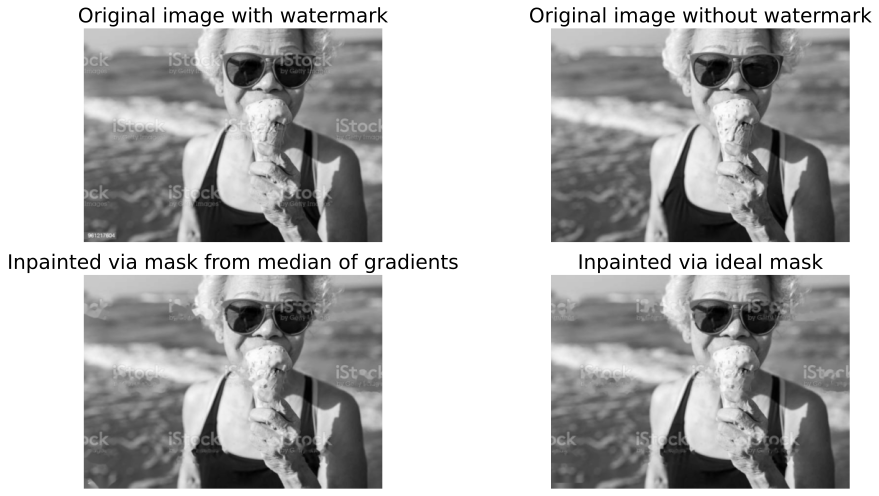

In [51]:
test_img = marked_imgs[-5]
clean_test_img = clean_imgs[-5]

ideal_mask = cv2.cvtColor(cv2.imread("dataset/istock/mask.jpg"), cv2.COLOR_BGR2GRAY)
ideal_mask = cv2.resize(ideal_mask, (ideal_mask.shape[1] * 600 // ideal_mask.shape[0], 600))
ideal_mask = np.pad(ideal_mask, ((0, 0), (0, max_width - ideal_mask.shape[1])))

inpaint_grad = cv2.inpaint(test_img, np.uint8(morph_grad)[:test_img.shape[0], :test_img.shape[1]], 3, cv2.INPAINT_TELEA)
inpaint_ideal = cv2.inpaint(test_img, np.uint8(ideal_mask)[:test_img.shape[0], :test_img.shape[1]], 3, cv2.INPAINT_TELEA)

fig = plt.figure(figsize=(15, 7))
fig.add_subplot(2, 2, 1)
plt.title(f"Original image with watermark", fontsize=20)
plt.imshow(test_img, cmap="gray")
plt.axis("off")

fig.add_subplot(2, 2, 2)
plt.title(f"Original image without watermark", fontsize=20)
plt.imshow(clean_test_img, cmap="gray")
plt.axis("off")

fig.add_subplot(2, 2, 3)
plt.title(f"Inpainted via mask from median of gradients", fontsize=20)
plt.imshow(inpaint_grad, cmap="gray")
plt.axis("off")

fig.add_subplot(2, 2, 4)
plt.title(f"Inpainted via ideal mask", fontsize=20)
plt.imshow(inpaint_ideal, cmap="gray")
plt.axis("off")

plt.tight_layout()

plt.show()